# Tratamiento de datos

In [ ]:
#@title Uso de gpu
#import os
#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')

#if gpus:
 #   try:
  #      logical_gpus = tf.config.list_logical_devices('GPU')
   #     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
   # except RuntimeError as e:
    #    print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
#@title Librerias

import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Lambda, RepeatVector, Reshape,concatenate, add,Conv2D, Conv2DTranspose,MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #img_to_array, array_to_img, load_img
import tensorflow as tf
import numpy as np
import yaml

2023-12-07 15:03:56.493095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 15:03:56.493685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 15:03:56.493712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 15:03:56.504374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#@title DataLoader
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
def obtener_rutas(directorio):
    return [os.path.join(directorio, archivo) for archivo in os.listdir(directorio) if archivo.endswith('.npy')]
# Función para cargar y procesar imágenes
def load_image(image_file):
    image = np.load(image_file)
    image = np.expand_dims(image, axis=-1)
    image = image.astype(np
                         .float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = tf.image.resize(image, [256, 256])
    return image

# Función para cargar datos para el autoencoder
def load_data_autoencoder(image_file):
    image = tf.numpy_function(load_image, [image_file], tf.float32)
    image.set_shape([256, 256, 1])
    return image, image  # Imagen como entrada y salida

# Función para cargar datos para el clasificador
def load_data_classifier(image_file, label):
    image = tf.numpy_function(load_image, [image_file], tf.float32)
    image.set_shape([256, 256, 1])
    return image, label  # Imagen como entrada y etiqueta como salida

# Obteniendo las rutas de los archivos
rutas_nodulos = obtener_rutas('/data/Datasets/LIDC/nodules2023')
rutas_no_nodulos = obtener_rutas('/data/Datasets/LIDC/nonNodules2023')

# Tomar una muestra aleatoria del 50% de los datos de cada tipo
half_size_nodules = len(rutas_nodulos) // 2
half_size_non_nodules = len(rutas_no_nodulos) // 2

sample_rutas_nodulos = np.random.choice(rutas_nodulos, half_size_nodules, replace=False)
sample_rutas_no_nodulos = np.random.choice(rutas_no_nodulos, half_size_non_nodules, replace=False)
# Combinar las rutas de muestra
sample_rutas = np.concatenate([sample_rutas_nodulos, sample_rutas_no_nodulos])

# Crear etiquetas para nódulos y no nódulos
etiquetas_nodulos = [1] * len(sample_rutas_nodulos)
etiquetas_no_nodulos = [0] * len(sample_rutas_no_nodulos)
etiquetas = np.concatenate([etiquetas_nodulos, etiquetas_no_nodulos])

# Dividir en conjuntos de entrenamiento y validación
rutas_train, rutas_val, etiquetas_train, etiquetas_val = train_test_split(
    sample_rutas, etiquetas, test_size=0.4, random_state=42
)

# Configurar DataLoaders
batch_size = 4

# DataLoader para el autoencoder
train_dataset_autoencoder = tf.data.Dataset.from_tensor_slices(rutas_train)
train_dataset_autoencoder = train_dataset_autoencoder.shuffle(len(rutas_train)).map(load_data_autoencoder).batch(batch_size)

val_dataset_autoencoder = tf.data.Dataset.from_tensor_slices(rutas_val)
val_dataset_autoencoder = val_dataset_autoencoder.shuffle(len(rutas_val)).map(load_data_autoencoder).batch(batch_size)

# DataLoader para el clasificador
train_dataset_classifier = tf.data.Dataset.from_tensor_slices((rutas_train, etiquetas_train))
train_dataset_classifier = train_dataset_classifier.shuffle(len(rutas_train)).map(load_data_classifier).batch(batch_size)

val_dataset_classifier = tf.data.Dataset.from_tensor_slices((rutas_val, etiquetas_val))
val_dataset_classifier = val_dataset_classifier.shuffle(len(rutas_val)).map(load_data_classifier).batch(batch_size)


# Reconstrucción

In [ ]:
#@title summary del modelo
from tensorflow.keras.metrics import MeanSquaredError
input_img = tf.keras.layers.Input(shape=(256, 256, 1))

# Encoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x) # Modificado para incluir padding='same'
x = tf.keras.layers.UpSampling2D((2, 2))(x)

decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_absolute_error', metrics=["accuracy", "mean_squared_error"])
autoencoder.summary()


In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configurar callbacks
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model_cell_unet.h5', verbose=1, save_best_only=True)

# Entrenar el modelo
history = autoencoder.fit(train_dataset_autoencoder,
                    callbacks=[earlystopper, checkpointer],
                    epochs=50, validation_data=val_dataset_autoencoder)

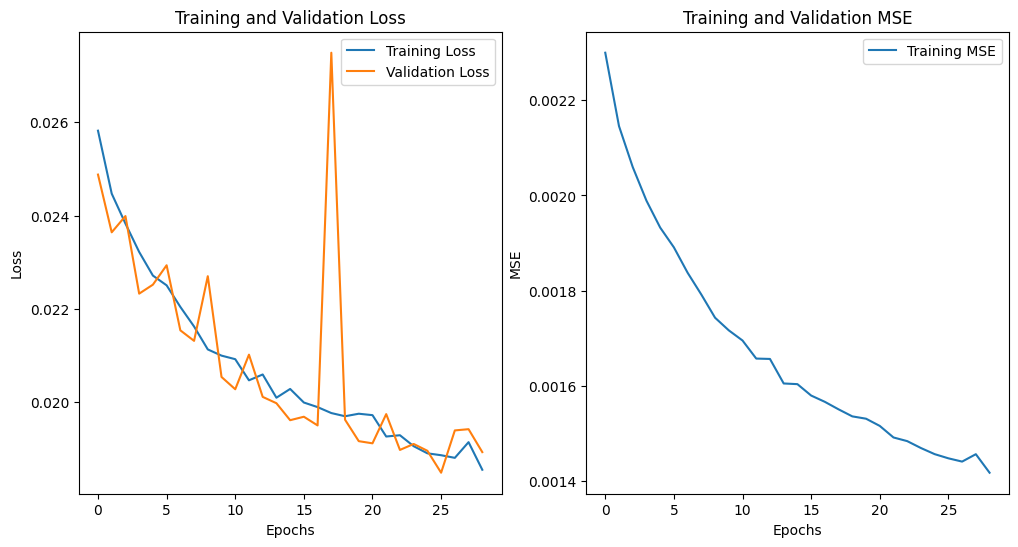

In [ ]:
#@title Visualización de perdidas
import matplotlib.pyplot as plt

# Extraer los valores de pérdida y MSE del historial
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']


# Crear la figura para la pérdida
plt.figure(figsize=(12, 6))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico del MSE
plt.subplot(1, 2, 2)
plt.plot(mse, label='Training MSE')

plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()


In [ ]:
#@title Metrica de predicciones
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicciones_auto = autoencoder.predict(test_images)
# Suponiendo que 'data' es tu array de cuatro dimensiones
test_flattened = test_images.reshape(40, -1)
pred_flattened = predicciones_auto.reshape(40, -1)
# Calcular el MSE utilizando scikit-learn
mse = mean_squared_error(test_flattened, pred_flattened)
mae = mean_absolute_error(test_flattened, pred_flattened)
print(f"MSE: {mse}", f"MAE: {mae} ")

2/2 [==============================] - 0s 24ms/step
MSE: 0.0014699012972414494 MAE: 0.018194271251559258 


2/2 [==============================] - 0s 21ms/step


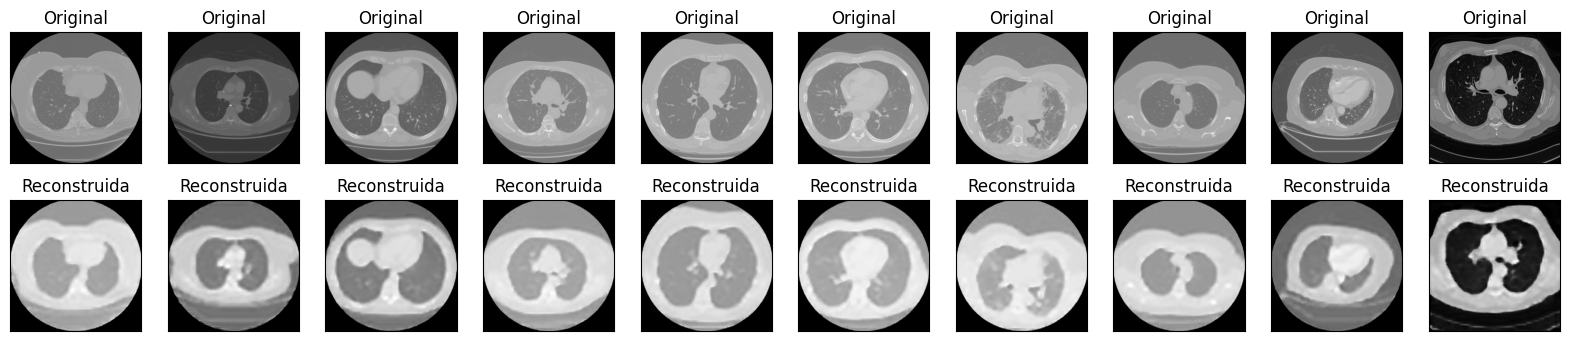

In [ ]:
#@title Imagenes reconstruidas
import matplotlib.pyplot as plt
import numpy as np

# Número de imágenes a visualizar
number_of_images = 10

# Extraer solo las imágenes del dataset
test_images = []
for image, _ in val_dataset_autoencoder.take(number_of_images):
    test_images.append(image.numpy())
test_images = np.vstack(test_images)

# Asegurarse de que las imágenes tienen la forma correcta
test_images = test_images.reshape(-1, 256, 256, 1)

# Realizar predicciones
predicted_images = autoencoder.predict(test_images)

# Graficar imágenes originales y reconstruidas
plt.figure(figsize=(20, 4))
for i in range(number_of_images):
    # Mostrar imagen original
    ax = plt.subplot(2, number_of_images, i + 1)
    plt.imshow(test_images[i].reshape(256, 256), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Mostrar imagen reconstruida
    ax = plt.subplot(2, number_of_images, i + 1 + number_of_images)
    plt.imshow(predicted_images[i].reshape(256, 256), cmap='gray')
    plt.title("Reconstruida")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#  Clasificador

In [ ]:
#@title Cargar modelo
from tensorflow.keras.models import Model
from tensorflow import keras
# Extrae la capa de embebido (encoded)
autoencoder = keras.models.load_model('model_cell_unet.h5')
#autoencoder.summary()
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_3').output)

In [ ]:
#@title Obtener embebidos de un conjunto de datos
def get_embeddings(dataset, encoder_model):
    embeddings = []
    labels = []

    # Iterar sobre el conjunto de datos
    for batch in dataset:
        images, batch_labels = batch
        batch_embeddings = encoder_model.predict(images)
        embeddings.append(batch_embeddings)
        labels.append(batch_labels)

    return np.concatenate(embeddings), np.concatenate(labels)

# Obtener embebidos y etiquetas para los conjuntos de entrenamiento y validación
train_embeddings, train_labels = get_embeddings(train_dataset_classifier, encoder_model)
val_embeddings, val_labels = get_embeddings(val_dataset_classifier, encoder_model)


In [ ]:
#@title Aplanar los embeddings
def flatten_embeddings(dataset):
    flat_embeddings = []
    labels = []
    for images, label in dataset.unbatch():
        # Obtén el embedding
        embedding = encoder_model.predict(tf.expand_dims(images, axis=0))
        # Aplana el embedding
        flat_embedding = embedding.flatten()
        flat_embeddings.append(flat_embedding)
        labels.append(label.numpy())
    return np.array(flat_embeddings), np.array(labels)

# Aplana los embeddings para los conjuntos de entrenamiento y validación
train_embeddings, train_labels = flatten_embeddings(train_dataset_classifier)
val_embeddings, val_labels = flatten_embeddings(val_dataset_classifier)




## RANDOM FOREST

In [ ]:
#@title Cargar RandomForest
from sklearn.ensemble import RandomForestClassifier
from joblib import load
# Entrenar el clasificador Random Forest
clf = RandomForestClassifier()
clf.fit(train_embeddings, train_labels)

# Evaluar el clasificador en el conjunto de validación
clf = load('modelo_random_forest.joblib')
val_predictions_RF = clf.predict(val_embeddings)

Accuracy: 0.6951871657754011

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.75      0.71       571
           1       0.71      0.64      0.67       551

    accuracy                           0.70      1122
   macro avg       0.70      0.69      0.69      1122
weighted avg       0.70      0.70      0.69      1122



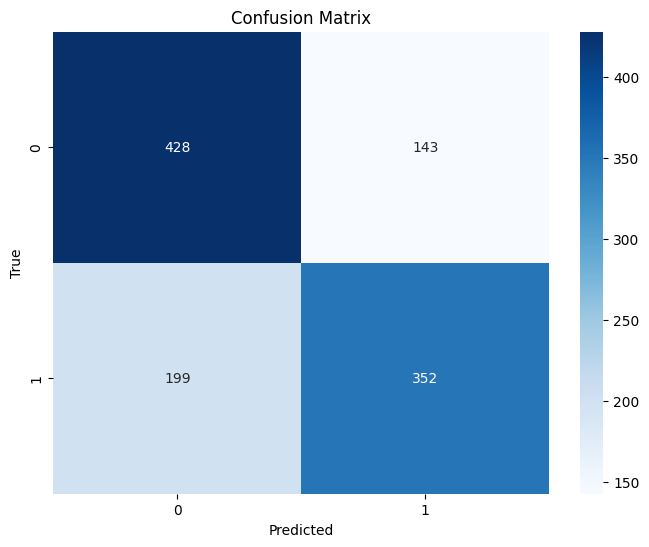

In [ ]:
#@title Metricas y matriz de confusión clasificación
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

clf = load('modelo_random_forest.joblib')
# Calcular la precisión
accuracy = accuracy_score(val_labels, val_predictions_RF)
print("Accuracy:", accuracy)

# Informe de clasificación
print("\nClassification Report:\n", classification_report(val_labels, val_predictions_RF))

# Matriz de confusión
cm = confusion_matrix(val_labels, val_predictions_RF)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Capas densas

In [ ]:
#@title Summary del modelo
entrada= Input(shape= train_embeddings[1].shape)
y= Dense(2096, activation='relu')(entrada)
y= BatchNormalization()(y)
y= Dense(1048, activation='relu')(y)
y= BatchNormalization()(y)
y= Dense(512, activation='relu')(y)
y= BatchNormalization()(y)
y= Dense(256, activation='relu')(y)
y= BatchNormalization()(y)
y= Dense(128, activation='relu')(y)
y= BatchNormalization()(y)
y= Dense(32, activation='relu')(y)
output_tensor = Dense(1, activation='sigmoid', name='output_tensor')(y)

# Crear el modelo
denso = tf.keras.models.Model(inputs=entrada, outputs=output_tensor)
denso.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8192)]            0         
                                                                 
 dense_30 (Dense)            (None, 2096)              17172528  
                                                                 
 batch_normalization_25 (Ba  (None, 2096)              8384      
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 1048)              2197656   
                                                                 
 batch_normalization_26 (Ba  (None, 1048)              4192      
 tchNormalization)                                               
                                                                 
 dense_32 (Dense)            (None, 512)               5370

In [ ]:
#@title entrenamiento denso
earlystopper_d = EarlyStopping(patience=3, verbose=1)
checkpointer_d = ModelCheckpoint('denso.h5', verbose=1, save_best_only=True)

denso.compile(optimizer=Adam(),
               loss='binary_crossentropy',  # O la función de pérdida que corresponda a tu problema
               metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])  # Puedes agregar más métricas si lo deseas

historial = denso.fit(train_embeddings, train_labels,
                      callbacks=[earlystopper_d, checkpointer_d],
                       batch_size=16,  # Tamaño del lote
                       epochs=50,  # Número de épocas
                       validation_split=0.2)  # Porcentaje de datos para validación


Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.5327 - precision_5: 0.5288 - recall_5: 0.4706
Epoch 1: val_loss improved from inf to 1.14631, saving model to denso.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 13s 140ms/step - loss: 0.7394 - accuracy: 0.5327 - precision_5: 0.5288 - recall_5: 0.4706 - val_loss: 1.1463 - val_accuracy: 0.5371 - val_precision_5: 0.6000 - val_recall_5: 0.0191
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.5654 - precision_5: 0.5623 - recall_5: 0.5309
Epoch 2: val_loss improved from 1.14631 to 0.80255, saving model to denso.h5
85/85 [==============================] - 12s 141ms/step - loss: 0.7019 - accuracy: 0.5654 - precision_5: 0.5623 - recall_5: 0.5309 - val_loss: 0.8025 - val_accuracy: 0.5490 - val_precision_5: 0.8571 - val_recall_5: 0.0382
Epoch 3/50
85/85 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5854 - precision_5: 0.5916 - recall_5: 0.5113
Epoch 3: val_loss improved from 0.80255 to 0.74383, saving model to denso.h5
85/85 [==============================] - 12s 139ms/step - loss: 0.6878 - accuracy: 0.5854 - precision_5: 0.5916 - recall_5: 0.5113 -

In [ ]:
#@title binarización de las prediciones
umbral = 0.5
val_predictions = denso.predict(val_embeddings)
# Convertir las predicciones a 0 o 1 basado en el umbral
predicciones_binarias = np.where(val_predictions > umbral, 1, 0)

36/36 [==============================] - 0s 8ms/step


Accuracy: 0.5249554367201426

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.64      0.58       571
           1       0.52      0.41      0.46       551

    accuracy                           0.52      1122
   macro avg       0.52      0.52      0.52      1122
weighted avg       0.52      0.52      0.52      1122



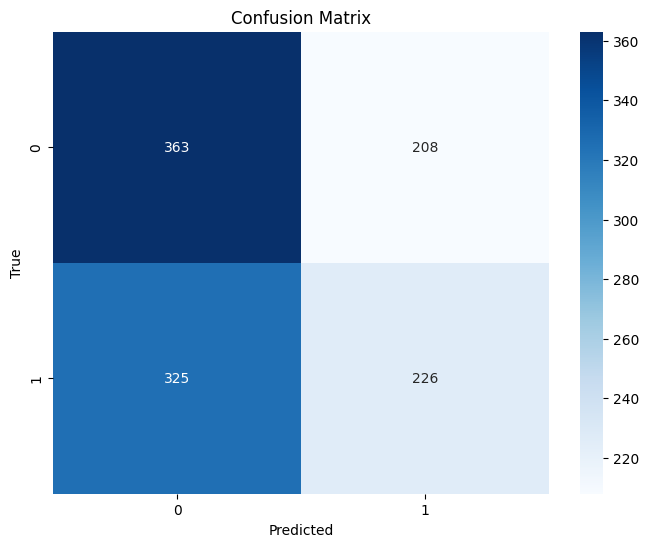

In [ ]:
#@title metricas y matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# Calcular la precisión
accuracy = accuracy_score(val_labels, predicciones_binarias)
print("Accuracy:", accuracy)

# Informe de clasificación
print("\nClassification Report:\n", classification_report(val_labels, predicciones_binarias))

# Matriz de confusión
cm = confusion_matrix(val_labels, predicciones_binarias)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

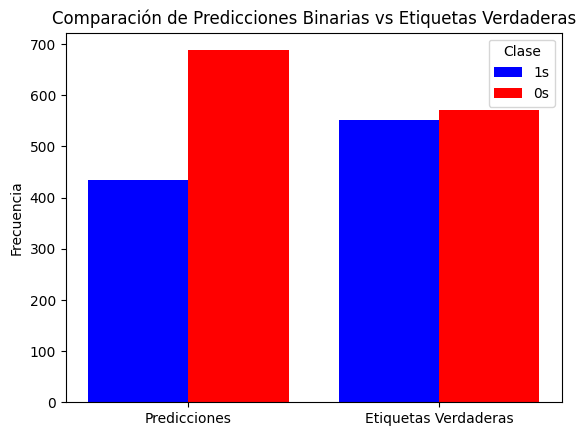

In [ ]:
#@title visualización gráfica de las prediciones
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'predicciones_binarias' es tu array de predicciones binarias
# y 'val_labels' son tus etiquetas verdaderas

# Contar las frecuencias de los 1s y 0s en las predicciones y las etiquetas verdaderas
predicciones_1s = np.sum(predicciones_binarias == 1)
etiquetas_1s = np.sum(val_labels == 1)
predicciones_0s = np.sum(predicciones_binarias == 0)
etiquetas_0s = np.sum(val_labels == 0)

# Crear un array con las posiciones de cada grupo de barras
bar_positions = np.arange(2)

# Crear las barras para los 1s
barras_1s = [predicciones_1s, etiquetas_1s]

# Crear las barras para los 0s
barras_0s = [predicciones_0s, etiquetas_0s]

# Graficar las barras
plt.bar(bar_positions - 0.2, barras_1s, width=0.4, color='blue', label='1s')
plt.bar(bar_positions + 0.2, barras_0s, width=0.4, color='red', label='0s')

# Añadir título y leyenda
plt.title('Comparación de Predicciones Binarias vs Etiquetas Verdaderas')
plt.xticks(bar_positions, ['Predicciones', 'Etiquetas Verdaderas'])
plt.ylabel('Frecuencia')
plt.legend(title='Clase')

# Mostrar la gráfica
plt.show()

